In [ ]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28*28).astype('float32') / 255.
x_test = x_test.reshape(10000, 28*28).astype('float32') / 255.

print('Shape of x_train: ' + str(x_train.shape)) 
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (60000, 784)
Shape of x_test: (10000, 784)
Shape of y_train: (60000,)
Shape of y_test: (10000,)


In [ ]:
import numpy

def to_one_hot(y, num_class=10):
    results = numpy.zeros((len(y), num_class))
    for i, label in enumerate(y):
        results[i, label] = 1.
    return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (60000, 10)
Shape of y_test_vec: (10000, 10)
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [ ]:
rand_indices = numpy.random.permutation(60000)
train_indices = rand_indices[0:10000]
valid_indices = rand_indices[10000:20000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (10000, 784)
Shape of y_tr: (10000, 10)
Shape of x_val: (10000, 784)
Shape of y_val: (10000, 10)


In [ ]:
from keras.layers import Dense, Input
from keras import models

input_img = Input(shape=(784,), name='input_img')

encode1 = Dense(128, activation='relu', name='encode1')(input_img)
encode2 = Dense(32, activation='relu', name='encode2')(encode1)
encode3 = Dense(8, activation='relu', name='encode3')(encode2)
bottleneck = Dense(2, activation='relu', name='bottleneck')(encode3)
decode1 = Dense(8, activation='relu', name='decode1')(bottleneck)
decode2 = Dense(32, activation='relu', name='decode2')(decode1)
decode3 = Dense(128, activation='relu', name='decode3')(decode2)
decode4 = Dense(784, activation='relu', name='decode4')(decode3)

ae = models.Model(input_img, decode4)

ae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 784)]             0         
_________________________________________________________________
encode1 (Dense)              (None, 128)               100480    
_________________________________________________________________
encode2 (Dense)              (None, 32)                4128      
_________________________________________________________________
encode3 (Dense)              (None, 8)                 264       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 18        
_________________________________________________________________
decode1 (Dense)              (None, 8)                 24        
_________________________________________________________________
decode2 (Dense)              (None, 32)                288   

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(ae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=ae, show_shapes=False,
    to_file='unsupervised_ae.pdf'
)


In [ ]:
from keras import optimizers

learning_rate = 1E-3 # to be tuned!

ae.compile(loss='mean_squared_error',
           optimizer=optimizers.RMSprop(lr=learning_rate))

In [ ]:
history = ae.fit(x_tr, x_tr, 
                 batch_size=128, 
                 epochs=100, 
                 validation_data=(x_val, x_val))

Epoch 1/100
79/79 [==============================] - 2s 9ms/step - loss: 0.0849 - val_loss: 0.0798
Epoch 2/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0800 - val_loss: 0.0796
Epoch 3/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0770 - val_loss: 0.0714
Epoch 4/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0706 - val_loss: 0.0688
Epoch 5/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0684 - val_loss: 0.0691
Epoch 6/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0669 - val_loss: 0.0653
Epoch 7/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0647 - val_loss: 0.0646
Epoch 8/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0629 - val_loss: 0.0623
Epoch 9/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0615 - val_loss: 0.0609
Epoch 10/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0604 - val_loss: 0.0611
Epoch 11/

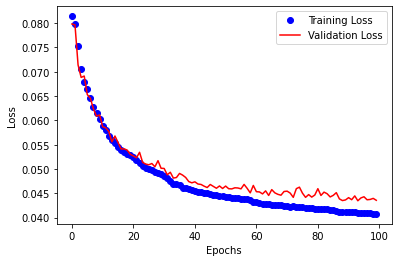

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

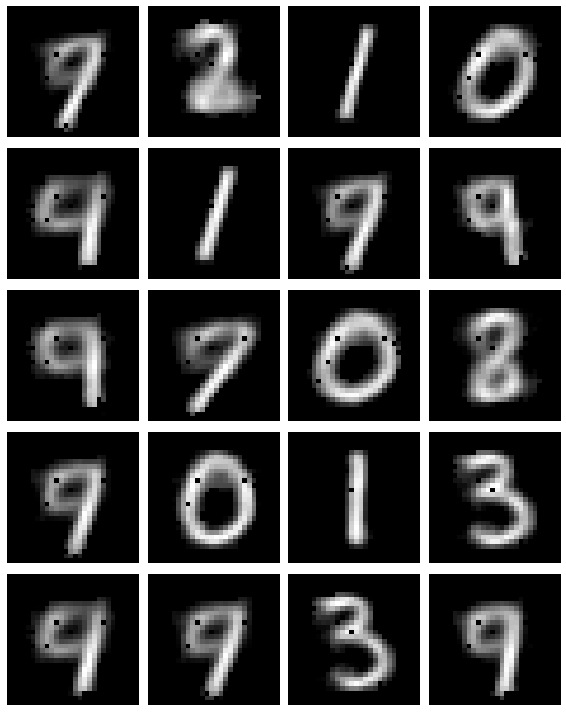

In [ ]:
ae_output = ae.predict(x_test).reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = ae_output
fname = 'reconstruct_ae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, numpy.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

In [ ]:
loss = ae.evaluate(x_test, x_test)
print('loss = ' + str(loss))

313/313 [==============================] - 1s 2ms/step - loss: 0.0435
loss = 0.04347898066043854


In [ ]:
# build the encoder network
ae_encoder = models.Model(input_img, bottleneck)
ae_encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 784)]             0         
_________________________________________________________________
encode1 (Dense)              (None, 128)               100480    
_________________________________________________________________
encode2 (Dense)              (None, 32)                4128      
_________________________________________________________________
encode3 (Dense)              (None, 8)                 264       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 18        
Total params: 104,890
Trainable params: 104,890
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# extract low-dimensional features from the test data
encoded_test = ae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

Shape of encoded_test: (10000, 2)


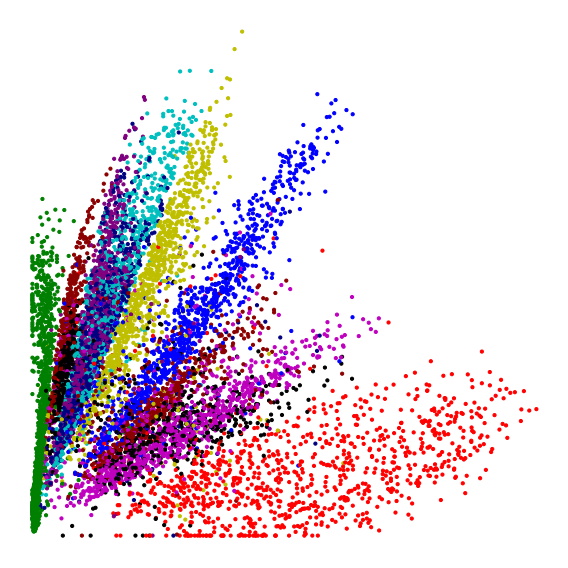

In [ ]:
colors = numpy.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'ae_code.pdf'
plt.savefig(fname)

In [ ]:
# extract the 2D features from the training, validation, and test samples
f_tr = ae_encoder.predict(x_tr)
f_val = ae_encoder.predict(x_val)
f_te = ae_encoder.predict(x_test)

print('Shape of f_tr: ' + str(f_tr.shape))
print('Shape of f_te: ' + str(f_te.shape))

Shape of f_tr: (10000, 2)
Shape of f_te: (10000, 2)


In [ ]:
from keras.layers import Dense, Input
from keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(128, activation='relu')(input_feat)
hidden2 = Dense(128, activation='relu')(hidden1)
output = Dense(10, activation='softmax')(hidden2)

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               384       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 18,186
Trainable params: 18,186
Non-trainable params: 0
_________________________________________________________________


In [ ]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Epoch 1/30
313/313 [==============================] - 2s 4ms/step - loss: 1.9707 - acc: 0.4214 - val_loss: 1.4470 - val_acc: 0.5614
Epoch 2/30
313/313 [==============================] - 1s 4ms/step - loss: 1.4165 - acc: 0.5587 - val_loss: 1.3031 - val_acc: 0.5597
Epoch 3/30
313/313 [==============================] - 1s 4ms/step - loss: 1.3027 - acc: 0.5822 - val_loss: 1.2234 - val_acc: 0.6031
Epoch 4/30
313/313 [==============================] - 1s 4ms/step - loss: 1.2038 - acc: 0.6163 - val_loss: 1.1766 - val_acc: 0.5971
Epoch 5/30
313/313 [==============================] - 1s 4ms/step - loss: 1.1809 - acc: 0.6208 - val_loss: 1.1386 - val_acc: 0.6120
Epoch 6/30
313/313 [==============================] - 1s 4ms/step - loss: 1.1358 - acc: 0.6321 - val_loss: 1.1148 - val_acc: 0.6144
Epoch 7/30
313/313 [==============================] - 1s 4ms/step - loss: 1.1126 - acc: 0.6372 - val_loss: 1.0925 - val_acc: 0.6240
Epoch 8/30
313/313 [==============================] - 1s 4ms/step - loss: 1.

In [ ]:
# build the supervised autoencoder network
from keras.layers import Dense, Input
from keras import models

input_img = Input(shape=(784,), name='input_img')

# encoder network
encode1 = Dense(128, activation='relu', name='encode1')(input_img)
encode2 = Dense(64, activation='relu', name='encode2')(encode1)
encode3 = Dense(32, activation='relu', name='encode3')(encode2)

# The width of the bottleneck layer must be exactly 2.
bottleneck = Dense(2, activation='relu', name='bottleneck')(encode3)

# decoder network
decode1 = Dense(32, activation='relu', name='decode1')(bottleneck)
decode2 = Dense(64, activation='relu', name='decode2')(decode1)
decode3 = Dense(128, activation='relu', name='decode3')(decode2)
decode4 = Dense(784, activation='sigmoid', name='decode4')(decode3)

# build a classifier upon the bottleneck layer
classifier1 = Dense(32, activation='relu', name='classifier1')(bottleneck)
classifier2 = Dense(128, activation='relu',name='classifier2')(classifier1)
classifier3 = Dense(10, activation='softmax', name='classifier3')(classifier2)# sig to soft

In [ ]:
# connect the input and the two outputs
sae = models.Model(input_img, [decode4, classifier3])

sae.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 784)]        0                                            
__________________________________________________________________________________________________
encode1 (Dense)                 (None, 128)          100480      input_img[0][0]                  
__________________________________________________________________________________________________
encode2 (Dense)                 (None, 64)           8256        encode1[0][0]                    
__________________________________________________________________________________________________
encode3 (Dense)                 (None, 32)           2080        encode2[0][0]                    
____________________________________________________________________________________________

In [ ]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(sae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=sae, show_shapes=False,
    to_file='supervised_ae.pdf'
)

# you can find the file "supervised_ae.pdf" in the current directory.

In [ ]:
from keras import optimizers

# compiling better ae model
sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=[1, 0.5], # to be tuned
            optimizer=optimizers.Adam(lr=1E-2))

# model fitting
history = sae.fit(x_tr, [x_tr, y_tr], 
                  batch_size=32, 
                  epochs=100, 
                  validation_data=(x_val, [x_val, y_val]))

Epoch 1/100
313/313 [==============================] - 3s 6ms/step - loss: 0.8141 - decode4_loss: 0.0754 - classifier3_loss: 1.4773 - val_loss: 0.4495 - val_decode4_loss: 0.0556 - val_classifier3_loss: 0.7878
Epoch 2/100
313/313 [==============================] - 2s 6ms/step - loss: 0.3873 - decode4_loss: 0.0544 - classifier3_loss: 0.6658 - val_loss: 0.3334 - val_decode4_loss: 0.0534 - val_classifier3_loss: 0.5601
Epoch 3/100
313/313 [==============================] - 2s 6ms/step - loss: 0.2909 - decode4_loss: 0.0537 - classifier3_loss: 0.4744 - val_loss: 0.2822 - val_decode4_loss: 0.0534 - val_classifier3_loss: 0.4576
Epoch 4/100
313/313 [==============================] - 2s 6ms/step - loss: 0.2485 - decode4_loss: 0.0533 - classifier3_loss: 0.3904 - val_loss: 0.2664 - val_decode4_loss: 0.0524 - val_classifier3_loss: 0.4280
Epoch 5/100
313/313 [==============================] - 2s 6ms/step - loss: 0.2171 - decode4_loss: 0.0525 - classifier3_loss: 0.3293 - val_loss: 0.2893 - val_decode4

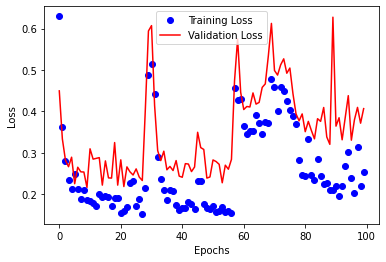

In [ ]:
# plotting evaluation matrics
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

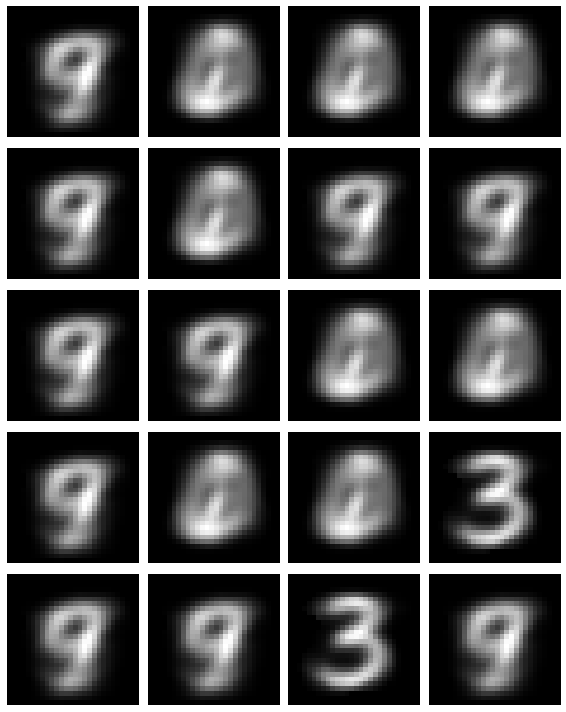

In [ ]:
# makeing predictions with updated
sae_output = sae.predict(x_test)[0].reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = sae_output
fname = 'reconstruct_sae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, numpy.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

In [ ]:
f_tr = sae.predict(x_tr)
f_val = sae.predict(x_val)
f_te = sae.predict(x_test)

In [ ]:
tr =numpy.concatenate( f_tr, axis=1 )
val =numpy.concatenate( f_val, axis=1 )
te =numpy.concatenate( f_te, axis=1 )

In [ ]:
input_feat = Input(shape=(tr.shape[1],))

hidden1 = Dense(512, activation='relu')(input_feat)
hidden2 = Dense(128, activation='relu')(hidden1)
hidden3 = Dense(128, activation='relu')(hidden2)
output = Dense(10, activation='softmax')(hidden3)

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 794)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               407040    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
Total params: 490,506
Trainable params: 490,506
Non-trainable params: 0
_________________________________________________________________


In [ ]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=0.0001),
                  metrics=['acc'])

# model fitting and validation
history = classifier.fit(tr, y_tr, 
                        #batch_size=32, 
                        epochs=30, 
                        validation_data=(val, y_val))

Epoch 1/30
313/313 [==============================] - 2s 5ms/step - loss: 1.7965 - acc: 0.5182 - val_loss: 1.2077 - val_acc: 0.8234
Epoch 2/30
313/313 [==============================] - 1s 4ms/step - loss: 0.9792 - acc: 0.8806 - val_loss: 0.6901 - val_acc: 0.8705
Epoch 3/30
313/313 [==============================] - 1s 4ms/step - loss: 0.5107 - acc: 0.9041 - val_loss: 0.5598 - val_acc: 0.8752
Epoch 4/30
313/313 [==============================] - 1s 4ms/step - loss: 0.3681 - acc: 0.9089 - val_loss: 0.5267 - val_acc: 0.8775
Epoch 5/30
313/313 [==============================] - 1s 4ms/step - loss: 0.3365 - acc: 0.9163 - val_loss: 0.5245 - val_acc: 0.8786
Epoch 6/30
313/313 [==============================] - 1s 4ms/step - loss: 0.3465 - acc: 0.9112 - val_loss: 0.5233 - val_acc: 0.8779
Epoch 7/30
313/313 [==============================] - 1s 4ms/step - loss: 0.3395 - acc: 0.9148 - val_loss: 0.5236 - val_acc: 0.8783
Epoch 8/30
313/313 [==============================] - 1s 5ms/step - loss: 0.

In [ ]:
from sklearn.metrics import classification_report
#evaluation on unseen test set
p=classifier.predict(te)
phat = [i.argmax() for i in p]

print(classification_report(phat,y_test))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1019
           1       0.97      0.99      0.98      1108
           2       0.92      0.91      0.92      1045
           3       0.83      0.88      0.85       960
           4       0.93      0.93      0.93       984
           5       0.63      0.73      0.68       762
           6       0.94      0.80      0.87      1129
           7       0.94      0.98      0.96       980
           8       0.84      0.79      0.82      1031
           9       0.88      0.90      0.89       982

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.88     10000
weighted avg       0.89      0.89      0.89     10000

